# GroundingDINO KITTI Fine-Tune (Notebook)

Generated from your repo at `/mnt/data/GroundingDINO-KITTI-FineTune/GroundingDINO-KITTI-FineTune-main` on 2025-10-20T05:43:05.

This notebook:
- Loads your **config** and **GroundingDINO** model
- Builds the **KITTI ODVG** dataset + DataLoader using your code
- Runs a **sanity forward** and a **mini training loop**
- Includes gradient checks & simple visualization

> Tip: run cell-by-cell the first time to validate paths, then use `Run All`.


## 1) Setup paths & environment

In [4]:
import os, sys, json, torch
from pathlib import Path

# Point to your repo root (already extracted in this environment)
REPO_ROOT = Path(r"/isis/home/hasana3/Open-GroundingDino").resolve()

# If running on your own machine, set this to the cloned repo folder:
# REPO_ROOT = Path("/path/to/GroundingDINO-KITTI-FineTune").resolve()

assert REPO_ROOT.exists(), f"Repo root not found: {REPO_ROOT}"
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print("🛠 Using repo root:", REPO_ROOT)

# Default config & paths from your repo
CFG_PATH = REPO_ROOT / "config" / "GroundingDINO_SwinB_cfg.py"

# 🔧 TODO: set these to your local environment
PRETRAIN_PATH = Path("../vlmtest/GroundingDINO/weights/groundingdino_swinb_cogcoor.pth")  # change if different
DATASET_META_PATH = Path("dataset_meta_kitti.json")  # or REPO_ROOT / "config" / "datasets_od_example.json"
OUTPUT_DIR = Path("./outputs/kitti_finetune_notebook")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("Config path:", CFG_PATH)
print("Weights:", PRETRAIN_PATH)
print("Output:", OUTPUT_DIR)

🛠 Using repo root: /isis/home/hasana3/Open-GroundingDino
Device: cuda
Config path: /isis/home/hasana3/Open-GroundingDino/config/GroundingDINO_SwinB_cfg.py
Weights: ../vlmtest/GroundingDINO/weights/groundingdino_swinb_cogcoor.pth
Output: outputs/kitti_finetune_notebook


## 2) Build model & criterion (from repo code)

In [5]:
from util.slconfig import SLConfig
from util.utils import clean_state_dict
from models import build_groundingdino

# Load config
args = SLConfig.fromfile(str(CFG_PATH))
args.device = device
# Avoid COCO eval dependency unless you enable it
args.use_coco_eval = False
# Some repos expect this attribute
if not hasattr(args, "amp"):
    args.amp = False

# Build model + criterion + postprocessors
model, criterion, postprocessors = build_groundingdino(args)
model.to(device); criterion.to(device)

# Load pretrained weights if available
if PRETRAIN_PATH.exists():
    ckpt = torch.load(PRETRAIN_PATH, map_location="cpu")
    if isinstance(ckpt, dict) and "model" in ckpt:
        sd = ckpt["model"]
    else:
        sd = ckpt
    missing = model.load_state_dict(clean_state_dict(sd), strict=False)
    print("✅ Weights loaded:", PRETRAIN_PATH)
    print("Missing/unexpected keys:", missing)
else:
    print("⚠️ Pretrained weights not found at:", PRETRAIN_PATH)

model.eval()

/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
load tokenizer done.


/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


final text_encoder_type: bert-base-uncased
load tokenizer done.
✅ Weights loaded: ../vlmtest/GroundingDINO/weights/groundingdino_swinb_cogcoor.pth
Missing/unexpected keys: _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


GroundingDINO(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MultiScaleDeformableAttention(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=Tr

## 3) Build KITTI-ODVG dataset & DataLoader

In [6]:
from datasets import build_dataset
from torch.utils.data import DataLoader

# Load dataset meta JSON
assert DATASET_META_PATH.exists(), f"Dataset meta not found: {DATASET_META_PATH}"
with open(DATASET_META_PATH, "r") as f:
    dataset_meta = json.load(f)

# Use first training entry by default
ds_info = dataset_meta["train"][0]
print("Dataset mode:", ds_info.get("dataset_mode"))
print("Image root:", ds_info.get("root"))
print("Anno:", ds_info.get("anno"))

# Some pipelines check this flag
if not hasattr(args, "fix_size"):
    args.fix_size = None

dataset = build_dataset("train", args, ds_info)

# Robust ODVG collate: keep paired (image, target) per sample
def collate_odvg(batch):
    batch = [b for b in batch if b is not None]
    images, targets = zip(*batch)
    return list(images), list(targets)

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_odvg
)

print(f"✅ DataLoader ready | batches={len(data_loader)} | samples={len(dataset)}")

Dataset mode: odvg
Image root: ../vlmtest/GroundingDINO/dataset/kitti/training/image_02
Anno: ../vlmtest/GroundingDINO/dataset/kitti/training/train_grounding_fixed.jsonl
../vlmtest/GroundingDINO/dataset/kitti/training/image_02 ../vlmtest/GroundingDINO/dataset/kitti/training/train_grounding_fixed.jsonl None
  == total images: 4520
✅ DataLoader ready | batches=2260 | samples=4520


## 4) One-batch sanity forward & loss (with weight patch for xy/hw)

In [7]:
from util.misc import nested_tensor_from_tensor_list
import torch

model.train(); criterion.train()

# Fetch one batch
samples_list, targets = next(iter(data_loader))

# Convert to NestedTensor + move to device
samples = nested_tensor_from_tensor_list(samples_list).to(device)

# Extract per-image captions
captions = [t["caption"] for t in targets]
cap_list  = [t["cap_list"] for t in targets]

# Safety: ensure one caption per image
B = samples.tensors.shape[0]
if len(captions) != B:
    print(f"⚠️ Fixing captions {len(captions)} -> {B}")
    captions = captions[:1] * B
    cap_list = cap_list[:1] * B

# Patch: copy bbox weights to xy/hw if not present
for k, v in list(criterion.weight_dict.items()):
    if k.startswith("loss_bbox"):
        criterion.weight_dict.setdefault(k.replace("bbox","xy"), v)
        criterion.weight_dict.setdefault(k.replace("bbox","hw"), v)

# Move tensor items in targets
targets = [{k: v.to(device) for k, v in t.items() if torch.is_tensor(v)} for t in targets]

# Forward & loss
with torch.cuda.amp.autocast(enabled=getattr(args, "amp", False)):
    outputs = model(samples, captions=captions)
    loss_dict = criterion(outputs, targets, cap_list, captions)
    total_loss = sum(loss_dict[k]*criterion.weight_dict[k] for k in loss_dict if k in criterion.weight_dict)

print("🔑 Loss keys:", list(loss_dict.keys())[:8], "...")
print("🧮 Total weighted loss:", float(total_loss))

# Gradient check
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
opt.zero_grad()
total_loss.backward()
opt.step()
print("✅ Single-step optimizer update complete.")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


🔑 Loss keys: ['loss_ce', 'loss_bbox', 'loss_giou', 'loss_xy', 'loss_hw', 'loss_ce_0', 'loss_bbox_0', 'loss_giou_0'] ...
🧮 Total weighted loss: 9.612808227539062
✅ Single-step optimizer update complete.


In [12]:
print("\n🧩 Gradient flow inspection:\n")

print(f"outputs.requires_grad: {outputs.tensors.requires_grad if hasattr(outputs, 'tensors') else hasattr(outputs, 'requires_grad')}")
for k, v in loss_dict.items():
    if torch.is_tensor(v):
        print(f"{k:25s} -> requires_grad={v.requires_grad} | grad_fn={v.grad_fn}")

print(f"\ntotal_loss.requires_grad: {total_loss.requires_grad}")
print(f"total_loss.grad_fn: {total_loss.grad_fn}")

# Backward pass to confirm gradients exist
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
optimizer.zero_grad()
total_loss.backward(retain_graph=True)

# Show a few parameter grads
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name:60s} | grad mean: {param.grad.mean().item():.3e}")
        break



🧩 Gradient flow inspection:

outputs.requires_grad: False
loss_ce                   -> requires_grad=True | grad_fn=<DivBackward0 object at 0x7ae133eee380>
loss_bbox                 -> requires_grad=True | grad_fn=<DivBackward0 object at 0x7ae133eee380>
loss_giou                 -> requires_grad=True | grad_fn=<DivBackward0 object at 0x7ae133eee380>
loss_xy                   -> requires_grad=False | grad_fn=None
loss_hw                   -> requires_grad=False | grad_fn=None
loss_ce_0                 -> requires_grad=True | grad_fn=<DivBackward0 object at 0x7ae133eee380>
loss_bbox_0               -> requires_grad=True | grad_fn=<DivBackward0 object at 0x7ae133eee380>
loss_giou_0               -> requires_grad=True | grad_fn=<DivBackward0 object at 0x7ae133eee380>
loss_xy_0                 -> requires_grad=False | grad_fn=None
loss_hw_0                 -> requires_grad=False | grad_fn=None
loss_ce_1                 -> requires_grad=True | grad_fn=<DivBackward0 object at 0x7ae133eee380>

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

## 5) Mini training loop (10 batches)

In [8]:
import numpy as np
from tqdm import tqdm

model.train(); criterion.train()
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

losses_hist = []
for i, (samples_list, targets) in enumerate(tqdm(data_loader, total=10)):
    if i >= 10: break
    samples = nested_tensor_from_tensor_list(samples_list).to(device)
    captions = [t["caption"] for t in targets]
    cap_list = [t["cap_list"] for t in targets]

    B = samples.tensors.shape[0]
    if len(captions) != B:
        captions = captions[:1] * B
        cap_list = cap_list[:1] * B

    targets = [{k: v.to(device) for k, v in t.items() if torch.is_tensor(v)} for t in targets]

    with torch.cuda.amp.autocast(enabled=getattr(args, "amp", False)):
        outputs = model(samples, captions=captions)
        loss_dict = criterion(outputs, targets, cap_list, captions)
        total_loss = sum(loss_dict[k]*criterion.weight_dict[k] for k in loss_dict if k in criterion.weight_dict)

    opt.zero_grad()
    total_loss.backward()
    opt.step()

    losses_hist.append(float(total_loss))
    print(f"Batch {i}: loss={float(total_loss):.4f}")

print("📉 Mean loss over 10 batches:", float(np.mean(losses_hist)))

  0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 10%|█         | 1/10 [00:01<00:09,  1.03s/it]

Batch 0: loss=5.8082


 20%|██        | 2/10 [00:01<00:06,  1.21it/s]

Batch 1: loss=5.1851


 30%|███       | 3/10 [00:02<00:05,  1.34it/s]

Batch 2: loss=7.1748


 40%|████      | 4/10 [00:03<00:04,  1.27it/s]

Batch 3: loss=11.8406


 50%|█████     | 5/10 [00:03<00:03,  1.49it/s]

Batch 4: loss=2.0838


 60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

Batch 5: loss=16.9462


 70%|███████   | 7/10 [00:05<00:01,  1.53it/s]

Batch 6: loss=9.4020


 80%|████████  | 8/10 [00:05<00:01,  1.64it/s]

Batch 7: loss=8.8152


 90%|█████████ | 9/10 [00:05<00:00,  1.80it/s]

Batch 8: loss=10.0795


100%|██████████| 10/10 [00:06<00:00,  1.84it/s]

Batch 9: loss=6.0065


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

📉 Mean loss over 10 batches: 8.334191417694091


## 6) Visualize a batch (GT boxes)

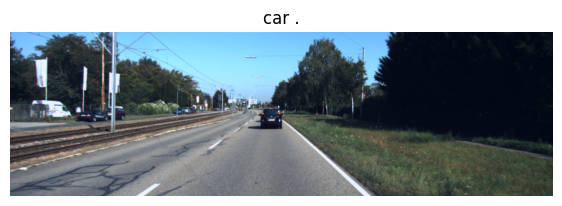

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def visualize_sample(samples, targets, idx=0, title=""):
    img = samples.tensors[idx].detach().cpu()
    # Normalize to [0,1] for display if needed
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)
    H, W = img.shape[1:]
    pil = TF.to_pil_image(img)
    plt.figure(figsize=(7,5))
    plt.imshow(pil)

    boxes = targets[idx]["boxes"].detach().cpu().clone()
    boxes[:, 0] *= W; boxes[:, 1] *= H; boxes[:, 2] *= W; boxes[:, 3] *= H

    ax = plt.gca()
    for (x,y,w,h) in boxes:
        ax.add_patch(plt.Rectangle((x,y), w,h, fill=False, color='lime', lw=2))
    plt.title(title or targets[idx].get("caption",""))
    plt.axis("off"); plt.show()

# Show from the last mini-batch in memory (re-run one batch if needed)
try:
    visualize_sample(samples, targets, idx=0)
except Exception as e:
    print("Visualization skipped:", e)

## 7) Save a quick checkpoint

In [10]:
ckpt_path = OUTPUT_DIR / "checkpoint_notebook.pth"
torch.save({"model": model.state_dict(), "args": vars(args)}, ckpt_path)
print("💾 Saved:", ckpt_path)

💾 Saved: outputs/kitti_finetune_notebook/checkpoint_notebook.pth
